In [1]:
import os
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, widgets
import numpy as np
import pandas as pd
from aicsimageio import AICSImage
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import binary_dilation
from scipy.signal import butter, filtfilt
from tqdm import tqdm
from skimage import io, filters, morphology, img_as_ubyte, img_as_uint
from skimage.filters import rank
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imsave
import cv2
from skimage import measure, feature, color
from skimage.draw import disk
from skimage.feature import blob_dog, blob_log, blob_doh
import heapq

In [2]:
# Open the .ims file
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_1_2024-01-11_Confocal_01.00.49_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_2_2024-01-11_Confocal_01.16.28_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_3_2024-01-11_Confocal_01.08.43_DragonflyUser.ims'

# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_1_2024-01-11_Confocal_01.23.49_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_2_2024-01-11_Confocal_01.30.50_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_3_2024-01-11_Confocal_01.40.34_DragonflyUser.ims'

# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous_2024-01-10_Confocal_22.39.44_DragonflyUser.ims'

In [3]:
file_name = '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous_2024-01-10_Confocal_22.39.44_DragonflyUser.ims'
image = AICSImage(file_name)
image_data = image.get_image_data("ZYX", S=0, T=0, C=0)

SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.


In [38]:
DoG_thresh = 0.3
lowerbound = 3
search_mod = 25
z_project = 5

BlurToggle = False
gkernal = (21, 21)

DilateToggle = False
dstructure = np.ones((3, 3))

In [39]:
def subtractflatfield(input_img):
    grayscale_img = input_img
    poly2d_fcn = lambda xy, a, b, c, d, e, f: a + b*xy[0] + c*xy[1] + d*xy[0]*xy[0] + e*xy[1]*xy[1] + f*xy[0]*xy[1]

    y, x = np.indices(grayscale_img.shape)

    x_co = x.flatten()
    y_co = y.flatten()
    pix_val = grayscale_img.flatten()

    p0 = [1, 1, 1, 1, 1, 1]
    popt, _ = curve_fit(poly2d_fcn, (x_co, y_co), pix_val, p0=p0) 
    flat_field_img = poly2d_fcn((x_co, y_co), *popt).reshape(grayscale_img.shape)
    fit_img = grayscale_img - (flat_field_img)

    return fit_img

In [40]:
def background_subtract(img_dat):
    x1 = np.min(img_dat)
    x2 = []
    for i in range(len(img_dat)):
        x2.append(img_dat[i] - x1)

    x2 = np.maximum(x2, 0)

    return x2

In [41]:
frame_mean = []
frame_min = []
frame_max = []
frame_std = []
frame_95 = []
frame_05 = []
for i in range(len(image_data)):
    frame_mean.append(np.mean(image_data[i]))
    frame_min.append(np.min(image_data[i]))
    frame_max.append(np.max(image_data[i]))
    frame_std.append(np.std(image_data[i]))
    frame_95.append(np.percentile(image_data[i], 95))
    frame_05.append(np.percentile(image_data[i], 5))

plusband = []
minusband = []
for i in range(len(image_data)):
    plusband.append(frame_mean[i] + frame_std[i])
    minusband.append(frame_mean[i] - frame_std[i])

frame_mean_top = []
frame_mean_bottom = []
for i in range(len(image_data)//2):
    frame_mean_bottom.append(frame_mean[i])

for i in range(len(image_data)//2, len(image_data)):
    frame_mean_top.append(frame_mean[i])

In [42]:
background_collect = background_subtract(frame_mean)
peaks2, _ = find_peaks(background_collect, height = 1)
print(peaks2)

[283]


In [43]:
hist_key = {}

for i in range(peaks2[0]-search_mod, peaks2[0]):
    if i > 0:
        hist_key[i] = image_data[i]

for i in range(peaks2[0], peaks2[0]+search_mod+1):
    if i < len(image_data):
        hist_key[i] = image_data[i]

hist_stdev = {}
for i in hist_key.keys():
    hist_stdev[i] = np.std(hist_key[i])

hist_laplace = {}
for i in hist_key.keys():
    hist_laplace[i] = cv2.Laplacian(hist_key[i], cv2.CV_64F)

hist_laplace_focusemeasure = {}
for i in hist_laplace.keys():
    hist_laplace_focusemeasure[i] = np.var(hist_laplace[i])

hist_tenengrad_focusemeasure = {}

for i in hist_key.keys():
    sobelx = cv2.Sobel(hist_key[i], cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(hist_key[i], cv2.CV_64F, 0, 1, ksize=5)

    magnitude = np.sqrt(sobelx**2 + sobely**2)

    hist_tenengrad_focusemeasure[i] = np.var(magnitude)

hist_max = {}
for i in hist_key.keys():
    hist_max[i] = np.max(hist_key[i])

In [44]:
weight_mat = [1, 1, 1]
focus_margins = []

stdev_two_largest = heapq.nlargest(2, hist_stdev.values())
laplace_two_largest = heapq.nlargest(2, hist_laplace_focusemeasure.values())
tenengrad_two_largest = heapq.nlargest(2, hist_tenengrad_focusemeasure.values())

stdev_stdev = np.std(list(hist_stdev.values()))
laplace_stdev = np.std(list(hist_laplace_focusemeasure.values()))
tenengrad_stdev = np.std(list(hist_tenengrad_focusemeasure.values()))

# Inverse standard deviation, of each focus measure, may be more appropriate
weight_mat[0] = 1 / stdev_stdev
weight_mat[1] = 1 / laplace_stdev
weight_mat[2] = 1 / tenengrad_stdev

focus_ensemble = []
focus_ensemble.append(max(hist_stdev, key=hist_stdev.get))
focus_ensemble.append(max(hist_laplace_focusemeasure, key=hist_laplace_focusemeasure.get))
focus_ensemble.append(max(hist_tenengrad_focusemeasure, key=hist_tenengrad_focusemeasure.get))

voting_power = []
for i in range(len(focus_ensemble)):
    voting_power.append((focus_ensemble[i], weight_mat[i]))

vote = {}
for frame_num, weighted_vote in voting_power:
    if frame_num in vote:
        vote[frame_num] += weighted_vote

    else:
        vote[frame_num] = weighted_vote

In [45]:
mem_layer = max(vote, key=vote.get)

bud_test = []
for i in range(z_project):
    bud_test.append(mem_layer-i-1)

bud_test_img = []
for i in bud_test:
    bud_test_img.append(hist_key[i])

bud_composite = np.max(bud_test_img, axis=0)

bud_img = bud_composite
test_flat = subtractflatfield(bud_img)

normalized_img = (bud_img - np.min(bud_img)) / (np.max(bud_img) - np.min(bud_img))
np.clip(normalized_img, 0, 1, out=normalized_img)
normalized_img = img_as_ubyte(normalized_img)

norm_flat = (test_flat - np.min(test_flat)) / (np.max(test_flat) - np.min(test_flat))
np.clip(norm_flat, 0, 1, out=norm_flat)
norm_flat = img_as_ubyte(norm_flat)

bin_fac = np.std(norm_flat)*3/np.mean(norm_flat)
threshold_value = bin_fac*256
if BlurToggle == True:
    norm_flat = cv2.GaussianBlur(norm_flat, gkernal, 0, 0)
_, binary_image = cv2.threshold(norm_flat, threshold_value, 256, cv2.THRESH_BINARY)
if DilateToggle == True:
    binary_image = binary_dilation(binary_image, structure=dstructure)

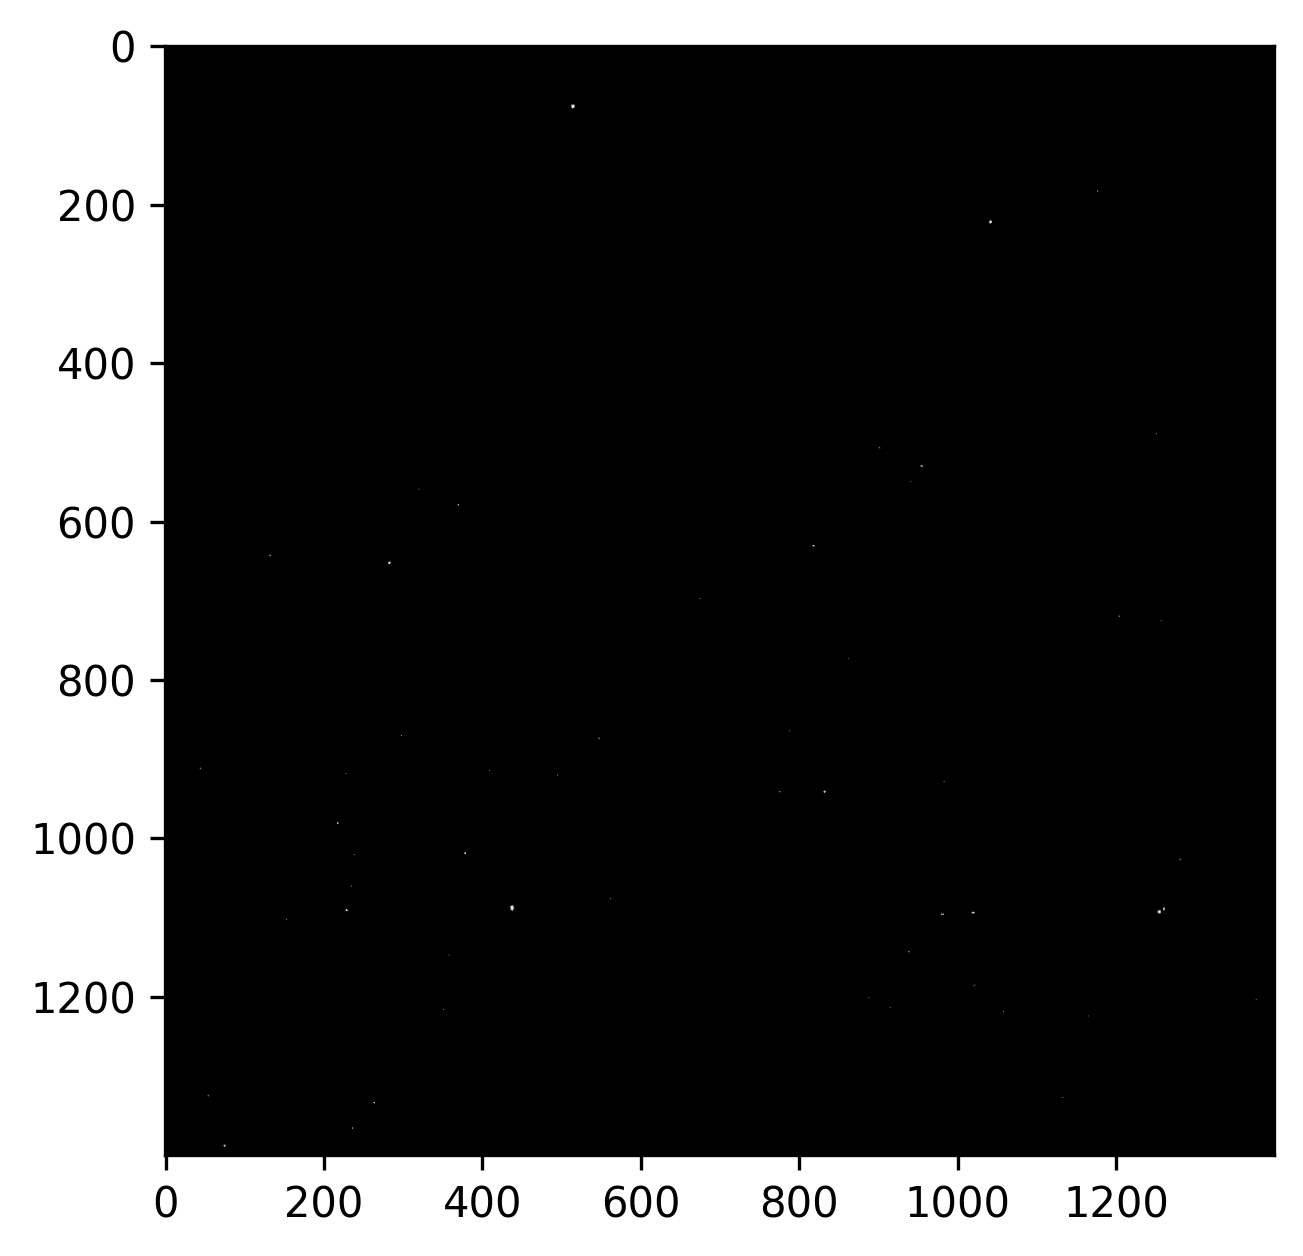

In [46]:
norm_thresh = np.percentile(norm_flat, 99.99)
norm_brightest = np.where(norm_flat > norm_thresh, norm_flat, 0)
plt.figure(dpi=300)
plt.imshow(norm_brightest, cmap='gray')
plt.show()

In [47]:
# plt.figure(dpi=150)
# plt.imshow(binary_image, cmap='gray')
# plt.axis('off')
# plt.show()

In [48]:
blobs_dog = blob_dog(norm_brightest, max_sigma=30, threshold=DoG_thresh)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)
min_radius = lowerbound  # Minimum acceptable blob radius
max_radius = 100  # Maximum acceptable blob radius

blobs_dog = [blob for blob in blobs_dog if min_radius <= blob[2] <= max_radius]

In [49]:
print(f'File Name: ' + os.path.basename(file_name))
bud_df = pd.DataFrame(blobs_dog, columns=['y-coord', 'x-coord', 'Radius'])
bud_df.index.name = 'Bud ID'
vote_array = [[k, v] for k, v in vote.items()]
vote_df = pd.DataFrame(vote_array, columns=['Stack Layer', 'Vote Weight'])
print(f'Membrane layer at: ' + str(mem_layer))
print(f'Budding layer at: ' + str(bud_test[0]))
print(f'Number of Detected Budding Events: ' + str(len(blobs_dog)))
print('------------------------------')
print('Final Vote Tally:')
print(vote_df.to_string(index=False))
print('------------------------------')
print(bud_df)

File Name: WT 1.2OD Nonporous_2024-01-10_Confocal_22.39.44_DragonflyUser.ims
Membrane layer at: 280
Budding layer at: 279
Number of Detected Budding Events: 0
------------------------------
Final Vote Tally:
 Stack Layer  Vote Weight
         280     0.095947
         282     0.000604
         279     0.000002
------------------------------
Empty DataFrame
Columns: [y-coord, x-coord, Radius]
Index: []


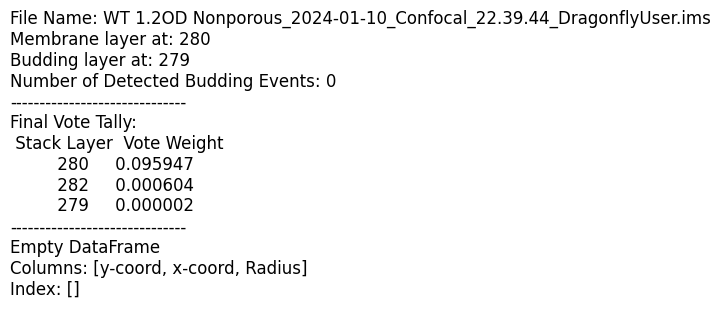

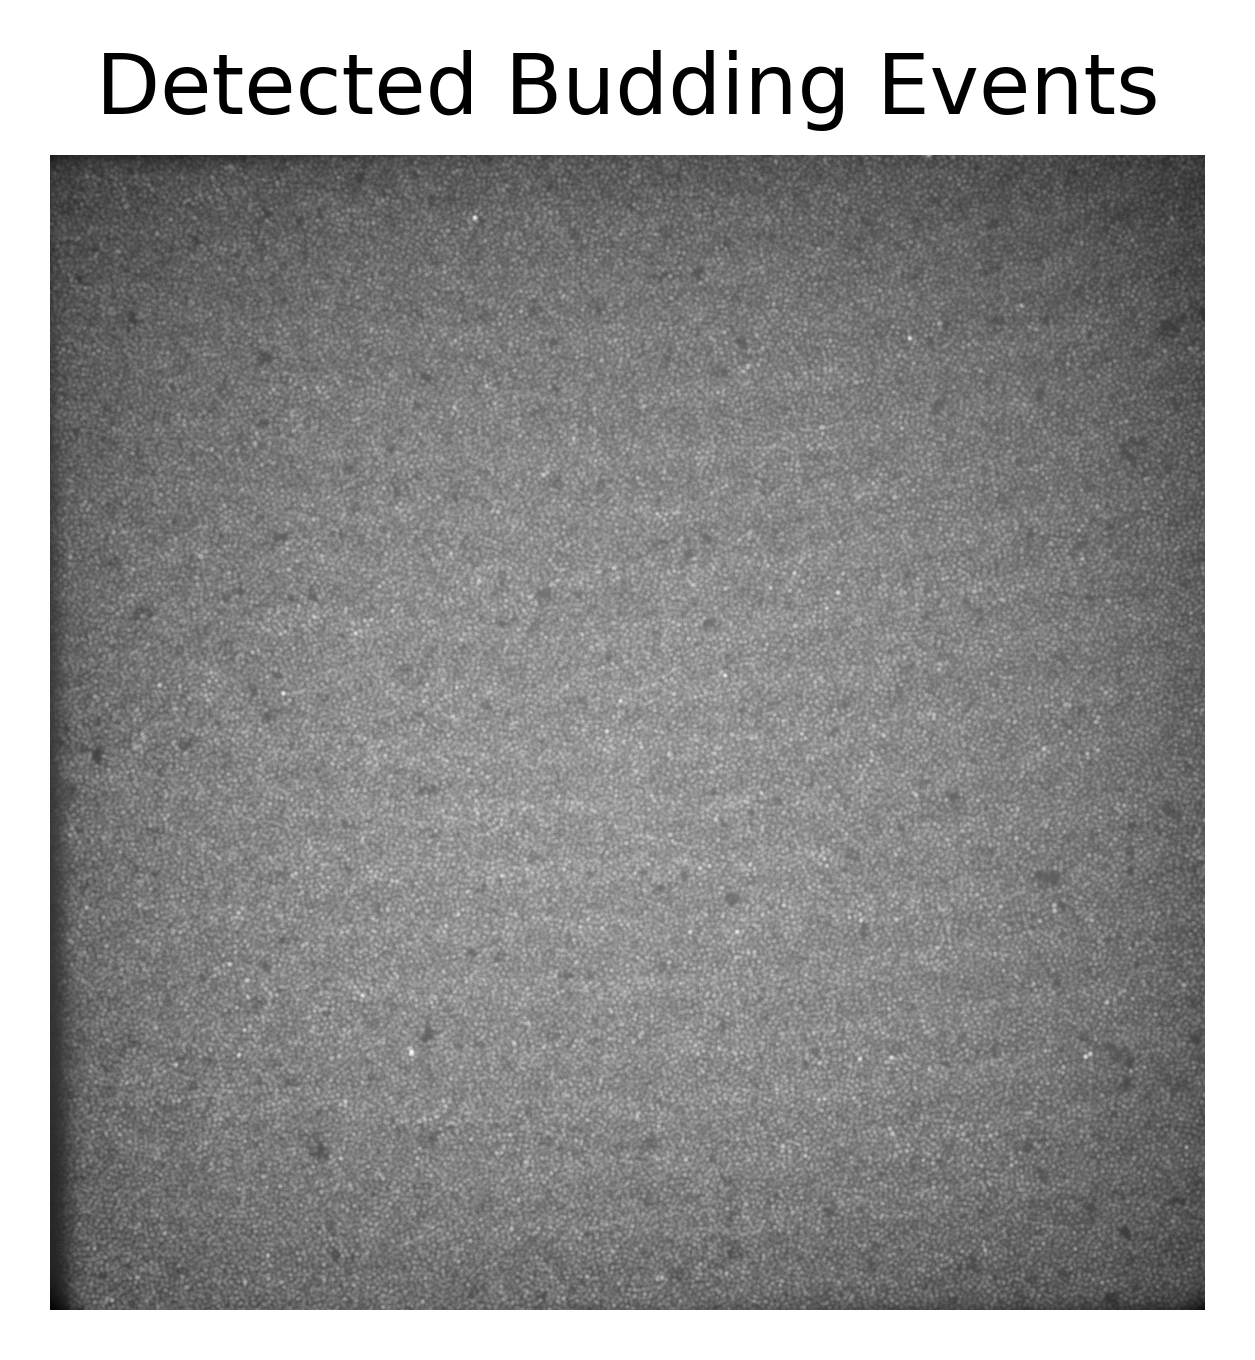

In [50]:
# Convert pandas dataframes and other variables to string and format it for display via matplotlb
bud_df_str = bud_df.to_string()
vote_df_str = vote_df.to_string(index=False)
text = f"""File Name: {os.path.basename(file_name)}
Membrane layer at: {mem_layer}
Budding layer at: {bud_test[0]}
Number of Detected Budding Events: {len(blobs_dog)}
------------------------------
Final Vote Tally:
{vote_df_str}
------------------------------
{bud_df_str}"""

fig = plt.figure(figsize=(9, 4))
plt.text(0, 1, text, fontsize=12, verticalalignment='top')
plt.axis('off')
plt.savefig('/Users/moose/Desktop/trace_ca-local/' + os.path.splitext(os.path.basename(file_name))[0] + '_stats.png', dpi=500)
plt.show()


fig, ax = plt.subplots(figsize=(3, 3), dpi=500)
ax.set_title('Detected Budding Events')
ax.imshow(normalized_img, cmap='gray')
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='green', linewidth=2, fill=False)
    ax.add_patch(c)
    ax.invert_yaxis()  # Invert the y-axis
ax.set_axis_off()

plt.savefig('/Users/moose/Desktop/trace_ca-local/' + os.path.splitext(os.path.basename(file_name))[0] + '_detected.png', dpi=500)
plt.show()